<a href="https://colab.research.google.com/github/hiydavid/time_series_forecasting/blob/main/notebooks/time_series_classification_with_tree_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Classification with Tree Models

---

Perform time series forecasting with machine learning (ensemble tree) models, with models / libraies such as:
1. Cesium [doc](http://cesium-ml.org/docs/feature_table.html)
2. Random Forecast Model
3. XGBoost Model
4. Decision Tree Model

---
# Loab libraries

In [2]:
!pip install cesium

In [86]:
# load libraries
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 3]

import warnings

import cesium
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from cesium import datasets
from cesium import featurize as ft

import scipy
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
path = '/content/drive/MyDrive/Colab/projects/time_series_forecasting/data/'

In [4]:
# load data
eeg = datasets.fetch_andrzejak()
type(eeg)

dict

In [5]:
# view eeg keys
eeg.keys()

dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])

---

# Model #1: Cesium (Feature Generation)

## Visualize

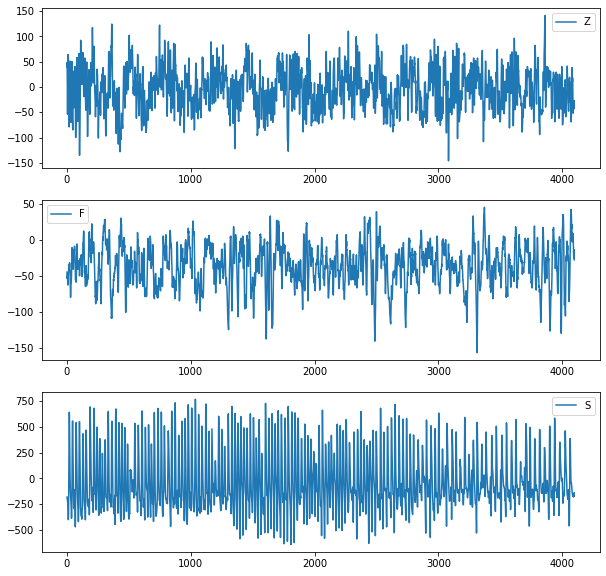

In [6]:
# visual
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

In [14]:
# view data types
print(type(eeg))
print(eeg.keys())
print(type(eeg['measurements']))
print(type(eeg["measurements"][0]))

<class 'dict'>
dict_keys(['times', 'measurements', 'classes', 'archive', 'header'])
<class 'list'>
<class 'numpy.ndarray'>


In [15]:
# view data shape
print(len(eeg['measurements']))
print(eeg['measurements'][0].shape)

500
(4097,)


## Generate Features

In [17]:
# use cesium to generate features
from cesium import featurize as ft

features_to_use = [
    "amplitude", "percent_beyond_1_std", "percent_close_to_median", 
    "skew", "max_slope"
    ]

fset_cesium = ft.featurize_time_series(
    times= eeg["times"], 
    values = eeg["measurements"], 
    errors = None, 
    features_to_use = features_to_use,
    scheduler = None
    )

In [41]:
# # use this to import the same data
# fset_cesium = pd.read_csv(path + 'full_eeg_data_features.csv', header = [0, 1])

In [22]:
# view features
print(fset_cesium.shape)
fset_cesium.head()

(500, 5)


feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


---
# Model #2: Random Forest

In [24]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
     fset_cesium.iloc[:, 1:6].values, 
     eeg["classes"], 
     random_state = 21
     )

In [25]:
# initiate rf model
clf = RandomForestClassifier(
    n_estimators = 10, 
    max_depth = 3,
    random_state = 21
    )

In [27]:
# fit model
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [28]:
# train score
clf.score(X_train, y_train)

0.6346666666666667

In [29]:
# test score
clf.score(X_test, y_test)

0.536

---
# Model #3: XGBoost

In [30]:
# initiate and fit model
model = xgb.XGBClassifier(
    n_estimators = 10, 
    max_depth = 3,
    random_state = 21)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=21,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [33]:
# train score
model.score(X_train, y_train)

0.6986666666666667

In [34]:
# test score
model.score(X_test, y_test)

0.6

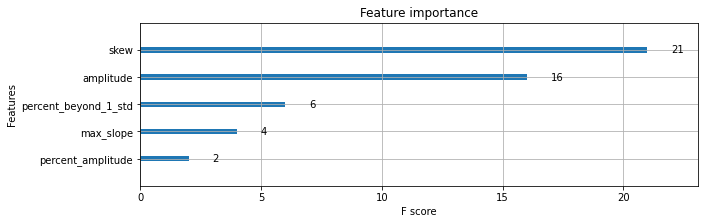

In [87]:
# feature importance
xgb.plot_importance(model)

---
# Model #3: Forecasting with Decision Tree

## Load Data

In [46]:
# get airline passenger data
ap = pd.read_csv(path + 'AirPassengers.csv', parse_dates = [0])
ap.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [47]:
# set index
ap.set_index('Month', inplace = True)
ap.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


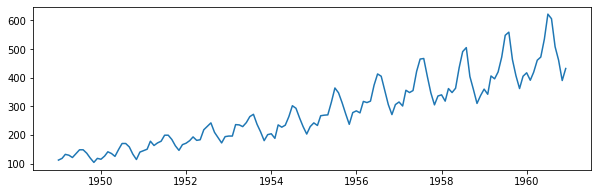

In [88]:
# plot ap
plt.plot(ap)

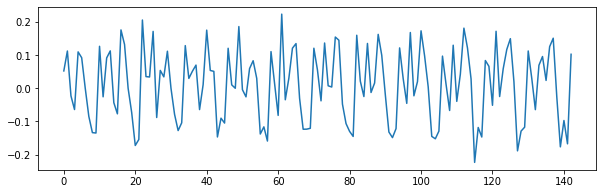

In [89]:
# detrend and differenced
plt.plot(np.diff(np.log(ap.values[:, 0])))

## Process Data

In [65]:
# diff ts
ts = np.diff(np.log(ap.values[:, 0]))
ts.shape

(143,)

In [66]:
# set time step
NSTEPS = 12
vals = np.hstack(
    [np.expand_dims(
        np.array(ts, dtype = np.float32), 
        axis = 1) for _ in range(NSTEPS )])

vals

array([[ 0.05218575,  0.05218575,  0.05218575, ...,  0.05218575,
         0.05218575,  0.05218575],
       [ 0.1121173 ,  0.1121173 ,  0.1121173 , ...,  0.1121173 ,
         0.1121173 ,  0.1121173 ],
       [-0.02298952, -0.02298952, -0.02298952, ..., -0.02298952,
        -0.02298952, -0.02298952],
       ...,
       [-0.0970834 , -0.0970834 , -0.0970834 , ..., -0.0970834 ,
        -0.0970834 , -0.0970834 ],
       [-0.1672513 , -0.1672513 , -0.1672513 , ..., -0.1672513 ,
        -0.1672513 , -0.1672513 ],
       [ 0.10227885,  0.10227885,  0.10227885, ...,  0.10227885,
         0.10227885,  0.10227885]], dtype=float32)

In [67]:
#
ts[0:NSTEPS]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629373, -0.0257525 ])

In [68]:
vals.shape

(143, 12)

In [69]:
nrow = vals.shape[0]
for lag in range(1, vals.shape[1]):
    vals[:(nrow - lag),lag] = vals[lag:,lag]
    vals[(nrow - lag):, lag] = np.nan

In [70]:
vals

array([[ 0.05218575,  0.1121173 , -0.02298952, ..., -0.13473259,
         0.12629372, -0.0257525 ],
       [ 0.1121173 , -0.02298952, -0.06402186, ...,  0.12629372,
        -0.0257525 ,  0.09134978],
       [-0.02298952, -0.06402186,  0.10948423, ..., -0.0257525 ,
         0.09134978,  0.11247798],
       ...,
       [-0.0970834 , -0.1672513 ,  0.10227885, ...,         nan,
                nan,         nan],
       [-0.1672513 ,  0.10227885,         nan, ...,         nan,
                nan,         nan],
       [ 0.10227885,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)

In [71]:
vals = vals[:(vals.shape[0] - NSTEPS + 1), :]
vals.shape

(132, 12)

In [75]:
# featurize
measures = [vals[i][0:(NSTEPS - 1)] for i in range(vals.shape[0])]
times = [[j for j in range(NSTEPS - 1)] for i in range(vals.shape[0])]

features_to_use = [
    "amplitude", "percent_beyond_1_std", "skew", 
    "max_slope", "percent_amplitude"
    ]

fset_ap = ft.featurize_time_series(
    times = times,
    values = measures,
    errors = None,
    features_to_use = features_to_use,
    scheduler = None
    )

fset_ap.columns = fset_ap.columns.droplevel(-1)

fset_ap.head()

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


(array([15.,  7.,  5., 23., 26., 17.,  6.,  6., 16., 11.]),
 array([0.12786029, 0.1352786 , 0.14269691, 0.15011522, 0.15753352,
        0.16495183, 0.17237014, 0.17978845, 0.18720675, 0.19462506,
        0.20204337]),
 <a list of 10 Patch objects>)

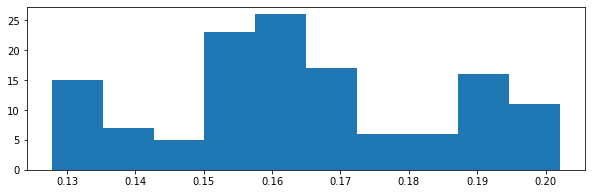

In [90]:
# view hist
plt.hist(fset_ap.amplitude)

(array([16., 40., 35.,  4., 15.,  9.,  1.,  9.,  2.,  1.]),
 array([0.12414427, 0.14138614, 0.15862801, 0.17586988, 0.19311176,
        0.21035363, 0.2275955 , 0.24483737, 0.26207924, 0.27932111,
        0.29656298]),
 <a list of 10 Patch objects>)

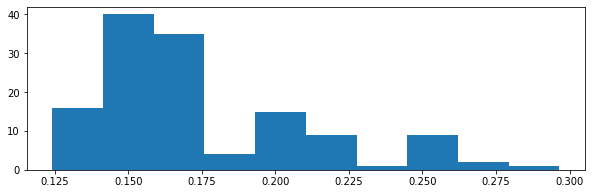

In [91]:
# view hist
plt.hist(fset_ap.percent_amplitude)

(array([ 9., 11.,  8., 23., 26., 25., 18.,  9.,  2.,  1.]),
 array([-0.56547007, -0.45117751, -0.33688495, -0.22259239, -0.10829984,
         0.00599272,  0.12028528,  0.23457784,  0.3488704 ,  0.46316296,
         0.57745551]),
 <a list of 10 Patch objects>)

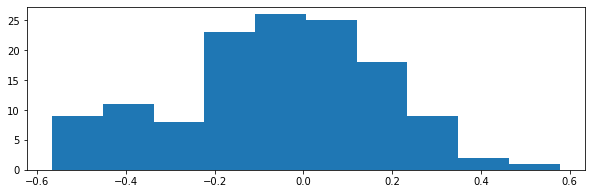

In [92]:
# view hist
plt.hist(fset_ap['skew'])

## Fit Model

In [81]:
# train-test
outcomes = vals[:, -1]
X_train, y_train = fset_ap.iloc[:100, :], outcomes[:100]
X_test, y_test   = fset_ap.iloc[100:, :], outcomes[100:]

In [82]:
# initiate model
model = xgb.XGBRegressor(
    n_estimators = 20, max_depth = 2, random_state = 21
    )

In [83]:
# fit model
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[03:57:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.454853
[1]	validation_0-rmse:0.408914
[2]	validation_0-rmse:0.367291
[3]	validation_0-rmse:0.330652
[4]	validation_0-rmse:0.297609
[5]	validation_0-rmse:0.269572
[6]	validation_0-rmse:0.241831
[7]	validation_0-rmse:0.219749
[8]	validation_0-rmse:0.198331
[9]	validation_0-rmse:0.178537
[10]	validation_0-rmse:0.161809
[11]	validation_0-rmse:0.149125
[12]	validation_0-rmse:0.137653
[13]	validation_0-rmse:0.128714
[14]	validation_0-rmse:0.122771
[15]	validation_0-rmse:0.118241
[16]	validation_0-rmse:0.114619
[17]	validation_0-rmse:0.112702
[18]	validation_0-rmse:0.112149
[19]	validation_0-rmse:0.112382


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

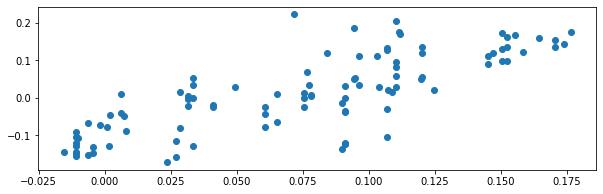

In [94]:
# view scatter of train
plt.scatter(model.predict(X_train), y_train)

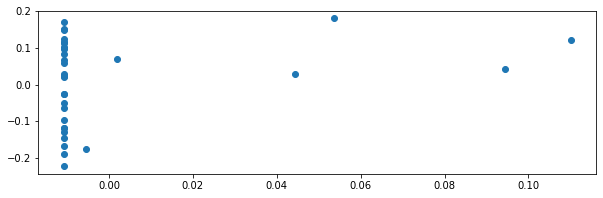

In [93]:
# view scatter of test
plt.scatter(model.predict(X_test), y_test)

In [96]:
# view performance
print(pearsonr(model.predict(X_train), y_train))
print(pearsonr(model.predict(X_test), y_test))

(0.7763253592748394, 2.3452056738489926e-21)
(0.26575179862682674, 0.1415369090490501)


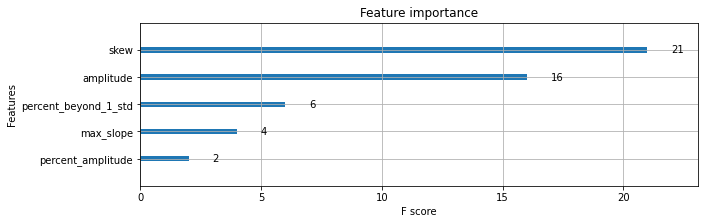

In [97]:
# feature importance
xgb.plot_importance(model)

In [98]:
# lost of repeating features
fset_ap.head()

feature,amplitude,percent_beyond_1_std,skew,max_slope,percent_amplitude
0,0.130513,0.454545,-0.155365,0.261026,0.132121
1,0.130513,0.545455,0.051772,0.261026,0.128461
2,0.130513,0.545455,0.037850,0.261026,0.128461
3,0.130513,0.454545,-0.192651,0.261026,0.132121
4,0.130513,0.454545,-0.233966,0.261026,0.132121


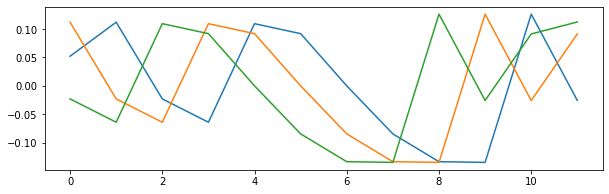

In [100]:
# need features that explains shape
plt.plot(vals[0])
plt.plot(vals[1])
plt.plot(vals[2])

## New Features

In [101]:
# new features
feats = np.zeros( (vals.shape[0], 6), dtype = np.float32)
for i in range(vals.shape[0]):
    feats[i, 0] = np.where(vals[i] == np.max(vals[i]))[0][0]
    feats[i, 1] = np.where(vals[i] == np.min(vals[i]))[0][0]
    feats[i, 2] = feats[i, 0] - feats[i, 1]
    feats[i, 3] = np.max(vals[i][-3:])
    feats[i, 4] = vals[i][-1] - vals[i][-2]
    feats[i, 5] = vals[i][-1] - vals[i][-3]

## New Model

In [105]:
# train-test
X_train, y_train = feats[:100, :], outcomes[:100]
X_test, y_test   = feats[100:, :], outcomes[100:]

In [106]:
# initiate & fit
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[04:01:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.459744
[1]	validation_0-rmse:0.418616
[2]	validation_0-rmse:0.380625
[3]	validation_0-rmse:0.346577
[4]	validation_0-rmse:0.315931
[5]	validation_0-rmse:0.287931
[6]	validation_0-rmse:0.263988
[7]	validation_0-rmse:0.241361
[8]	validation_0-rmse:0.222136
[9]	validation_0-rmse:0.205052
[10]	validation_0-rmse:0.189806
[11]	validation_0-rmse:0.175841
[12]	validation_0-rmse:0.162495
[13]	validation_0-rmse:0.150479
[14]	validation_0-rmse:0.139907
[15]	validation_0-rmse:0.131403
[16]	validation_0-rmse:0.122909
[17]	validation_0-rmse:0.115215
[18]	validation_0-rmse:0.108389
[19]	validation_0-rmse:0.102514


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=20,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=21,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

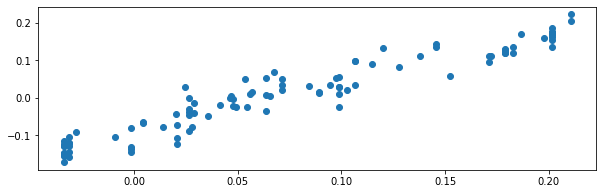

In [110]:
# scatter of train
plt.scatter(model.predict(X_train), y_train)

In [111]:
print(pearsonr(model.predict(X_train), y_train))
print(spearmanr(model.predict(X_train), y_train))

(0.9574312130551085, 1.1011058590058442e-54)
SpearmanrResult(correlation=0.9608384510376272, pvalue=2.0044276644436398e-56)


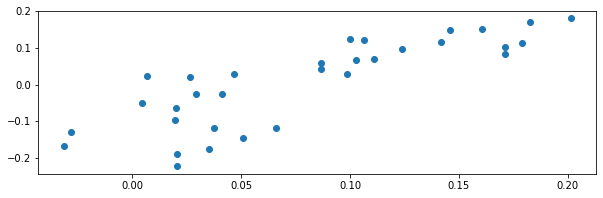

In [112]:
# scatter of test
plt.scatter(model.predict(X_test), y_test)

In [113]:
print(pearsonr(model.predict(X_test), y_test))
print(spearmanr(model.predict(X_test), y_test))

(0.8295710199019659, 4.3988566454564714e-09)
SpearmanrResult(correlation=0.8506737877812696, pvalue=7.029762268431634e-10)
